### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import PIL.Image as Image
import random
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

### Data

#### Setting up Kaggle on Colab

In [ ]:
!pip install kaggle

In [3]:
!mkdir ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

Uploaded my kaggle.json file here

In [5]:
!mv kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle --version

Kaggle API 1.5.12


#### Download Data

I will download the Digit Recognizer data from Kaggle.

Link to data: https://www.kaggle.com/competitions/digit-recognizer/data

In [8]:
!kaggle competitions download -c digit-recognizer

 85% 13.0M/15.3M [00:01<00:00, 15.3MB/s]
100% 15.3M/15.3M [00:01<00:00, 9.47MB/s]


In [9]:
!unzip -q digit-recognizer.zip

#### Analyze data

From the website, I can tell a lot about the data.

1. Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a value between 0 and 255(inclusive). The images are grayscale so their dimensions are 28x28x1.

2. The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user.

In [10]:
train = pd.read_csv("train.csv")

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


From this I can tell that there are 42000 images as train data.

In [12]:
np.sort(train["label"].unique())

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

There are 10 total classes to classify.

#### Unpack data to directories

In [13]:
if not os.path.exists("digit recognizer"):
    os.makedirs("digit recognizer")

In [14]:
train_dir = os.path.join("digit recognizer", "train")

if not os.path.exists(train_dir):
    os.makedirs(train_dir)

In [15]:
for i in range(10):
    os.makedirs(os.path.join(train_dir, str(i)))

In [16]:
def upload_image(split, index, row):
    #create the image(numpy array)
    label = row["label"]
    img = Image.fromarray(np.uint8(row.iloc[1:].values.reshape(28, 28)))

    # Save the image
    destination = os.path.join("digit recognizer", split, str(label), "img_"+str(index)+".jpg")
    img.save(destination)

In [17]:
for index, row in train.iterrows():
    upload_image("train", index, row)

Now I will move 20% of the files from each class to a validation folder

In [18]:
val_dir = os.path.join("digit recognizer", "validation")

if not os.path.exists(val_dir):
    os.makedirs(val_dir)

In [19]:
for i in range(10):
    os.makedirs(os.path.join(val_dir, str(i)))

In [20]:
def move_files(source_dir, destination_dir, amount):
    num_val_files = int(amount*len(os.listdir(source_dir)))
    files = os.listdir(source_dir)
    val_files = random.sample(files, k=num_val_files)
    
    for val_file in val_files:
        src = os.path.join(source_dir, val_file)
        dst = os.path.join(destination_dir, val_file)
        os.rename(src, dst)

In [21]:
for i in range(10):
    move_files(os.path.join(train_dir, str(i)), os.path.join(val_dir, str(i)), 0.2)

In [22]:
total_files = 0

for i in range(10):
    total_files += len(os.listdir(os.path.join(train_dir, str(i)))) + len(os.listdir(os.path.join(val_dir, str(i))))

In [23]:
total_files

42000

This was just to make sure I have all the files

#### Display random images

In [24]:
def display_random_images(split, picture_class, num_images):
    random_filenames = random.sample(os.listdir(os.path.join("digit recognizer", split, picture_class)), num_images)

    fig, axes = plt.subplots(nrows= int(np.ceil(num_images/5)), ncols=5, figsize=(10, 5))

    axes = axes.ravel()

    for i, filename in enumerate(random_filenames):
        axes[i].imshow(Image.open(os.path.join("digit recognizer", split, picture_class, filename)))
    
    plt.show()

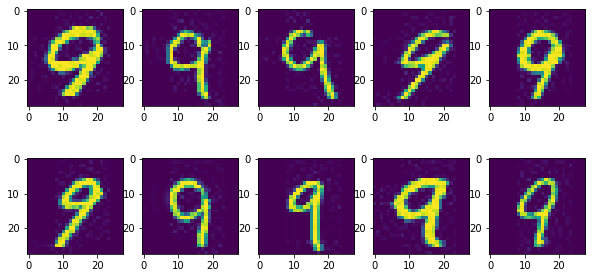

In [25]:
display_random_images("train", "9", 10)

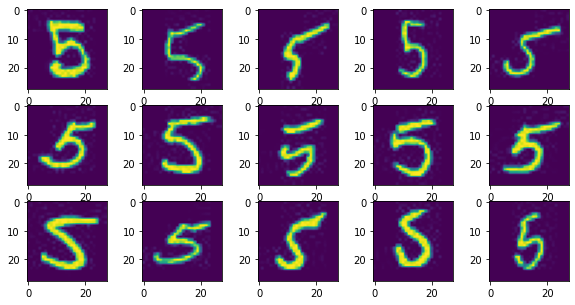

In [26]:
display_random_images("train", "5", 15)

### Create Datasets

#### Create Datasets using ImageDataGenerator

In [27]:
def create_dataset(split, batch_size):
    image_directory = os.path.join('digit recognizer', split)

    imageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    image_generator = imageDataGenerator.flow_from_directory(
        image_directory,
        target_size=(28, 28),
        color_mode='grayscale',
        classes=None,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True    
        )
    
    return image_generator

In [28]:
BATCH_SIZE = 32

In [29]:
train_ds = create_dataset("train", BATCH_SIZE)
val_ds = create_dataset("validation", BATCH_SIZE)

Found 33604 images belonging to 10 classes.
Found 8396 images belonging to 10 classes.


#### Analyze Datasets

In [30]:
print(f"The train image generator has {len(train_ds)} batches, each with a batch size of {BATCH_SIZE}")
print(f"The validation image generator has {len(val_ds)} batches, each with a batch size of {BATCH_SIZE}")

The train image generator has 1051 batches, each with a batch size of 32
The validation image generator has 263 batches, each with a batch size of 32


In [31]:
batch = train_ds.next()

In [32]:
len(batch)

2

In [33]:
type(batch[0])

numpy.ndarray

In [34]:
batch[0].shape

(32, 28, 28, 1)

32 images of 28x28x1

In [35]:
type(batch[1])

numpy.ndarray

In [36]:
batch[1].shape

(32, 10)

32 labels. Each label is a list of size 10.

In [37]:
def display_images_from_dataset(batch, num_images):
    images = batch[0]
    labels = batch[1]

    batch_size = len(images)

    random_indices = random.sample(range(batch_size), num_images)

    fig, axes = plt.subplots(nrows= int(np.ceil(num_images/5)), ncols=5, figsize=(10, 5))

    axes = axes.ravel()

    for i, index in enumerate(random_indices):
        axes[i].imshow(np.squeeze(images[index]))
        axes[i].set_title(str(np.argmax(labels[index])))
    
    plt.show()

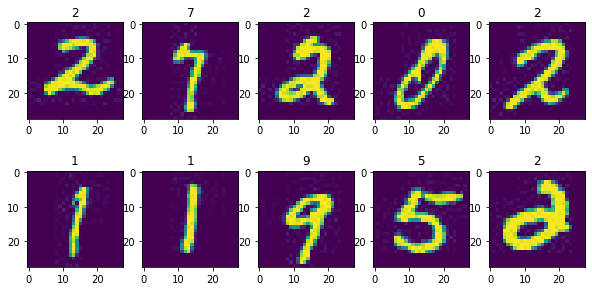

In [38]:
display_images_from_dataset(train_ds.next(), 10)

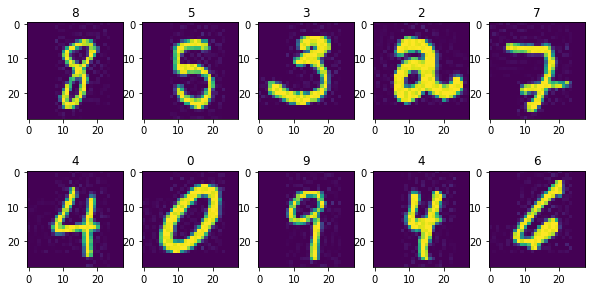

In [39]:
display_images_from_dataset(val_ds.next(), 10)

### Create Model

In [40]:
print("TF version:", tf.__version__)
#print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.9.2
GPU is available


In [41]:
def build_model():
    model = Sequential([
        Conv2D(32, 5, input_shape=(28, 28, 1), activation = "relu", padding = "same"),
        Dropout(0.2),
        Conv2D(64, 5, activation = "relu", padding = "same"),
        Dropout(0.2),
        Conv2D(128, 5, activation = "relu", padding = "same"),
        Dropout(0.2),
        Conv2D(256, 5, activation = "relu", padding = "same"),
        Dropout(0.2),
        Flatten(),
        Dense(10, activation = "softmax")
    ])

    return model

In [42]:
model = build_model()

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        51264     
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       204928    
                                                                 
 dropout_2 (Dropout)         (None, 28, 28, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 256)       8

In [44]:
model.compile(optimizer="adam", 
              loss="categorical_crossentropy",
              metrics = ['accuracy'])

In [45]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=5,
    mode='min',
    restore_best_weights=True)

In [46]:
num_training_images = 0
num_validation_images = 0

for i in range(10):
    num_training_images += len(os.listdir(os.path.join(train_dir, str(i))))
    num_validation_images += len(os.listdir(os.path.join(val_dir, str(i))))

In [47]:
print(num_training_images, num_validation_images)

33604 8396


In [48]:
steps_per_epoch = num_training_images//BATCH_SIZE
validation_steps = num_validation_images//BATCH_SIZE

In [49]:
hist = model.fit(
    train_ds,
    epochs=50, 
    validation_data=val_ds,
    callbacks = [reduce_lr, early_stopping],
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose = 1)

Epoch 1/50
1050/1050 [==============================] - 34s 24ms/step - loss: 0.1483 - accuracy: 0.9542 - val_loss: 0.0914 - val_accuracy: 0.9758 - lr: 0.0010
Epoch 2/50
1050/1050 [==============================] - 29s 28ms/step - loss: 0.0531 - accuracy: 0.9839 - val_loss: 0.0481 - val_accuracy: 0.9859 - lr: 0.0010
Epoch 3/50
1050/1050 [==============================] - 25s 24ms/step - loss: 0.0400 - accuracy: 0.9874 - val_loss: 0.0392 - val_accuracy: 0.9890 - lr: 0.0010
Epoch 4/50
1050/1050 [==============================] - 25s 24ms/step - loss: 0.0300 - accuracy: 0.9908 - val_loss: 0.0553 - val_accuracy: 0.9859 - lr: 0.0010
Epoch 5/50
1050/1050 [==============================] - 25s 24ms/step - loss: 0.0254 - accuracy: 0.9923 - val_loss: 0.0532 - val_accuracy: 0.9872 - lr: 0.0010
Epoch 6/50
1050/1050 [==============================] - 25s 24ms/step - loss: 0.0213 - accuracy: 0.9929 - val_loss: 0.0573 - val_accuracy: 0.9865 - lr: 0.0010
Epoch 7/50
1050/1050 [========================

### Save Model

In [56]:
model_save_path = 'Digit_Recognizer_Kaggle_Model.h5' 
model.save(model_save_path)

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [59]:
!cp Digit_Recognizer_Kaggle_Model.h5 '/content/drive/My Drive/Neural Networks/Computer Vision/'

### Load Model

In [60]:
model_path = '/content/drive/My Drive/Neural Networks/Computer Vision/Digit_Recognizer_Kaggle_Model.h5'
new_model = tf.keras.models.load_model(model_path)

### Fill Out Sample Submission

In [50]:
test_df = pd.read_csv("test.csv")

In [51]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
submission_df = pd.read_csv("sample_submission.csv")

In [53]:
submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [54]:
submission_df["Label"][0] = 0

In [84]:
for index, row in test_df.iterrows():
    img = row.values.reshape(28, 28)
    prediction = np.argmax(new_model(np.expand_dims(img, axis=0)))
    submission_df["Label"][index] = prediction

In [85]:
submission_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


I will display some images and their prediction

In [107]:
def get_image_and_prediction(df, model):
    random_index = random.sample(range(len(df)), 1)[0]
    img = df.iloc[random_index].values.reshape(28, 28)
    prediction = np.argmax(model(np.expand_dims(img, axis=0)))
    return img, prediction

In [113]:
def display_random_images_and_prediction(df, model, num_images):
    fig, axes = plt.subplots(nrows= int(np.ceil(num_images/5)), ncols=5, figsize=(10, 7))

    axes = axes.ravel()

    for i in range(num_images):
        img, prediction = get_image_and_prediction(df, model)
        axes[i].imshow(img)
        axes[i].title.set_text(prediction)
    
    plt.show()

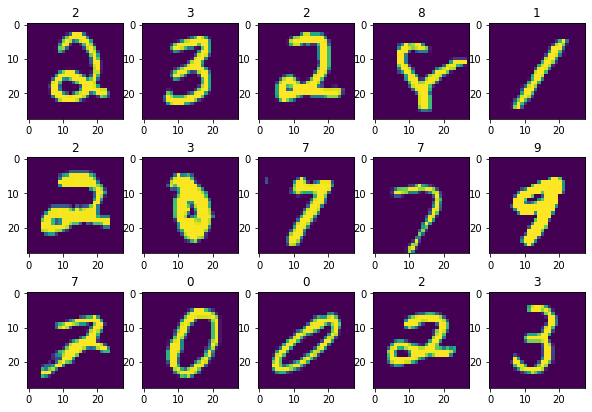

In [114]:
display_random_images_and_prediction(test_df, new_model, 15)

In [115]:
submission_df.to_csv("completed_sample_submission.csv", index = False)

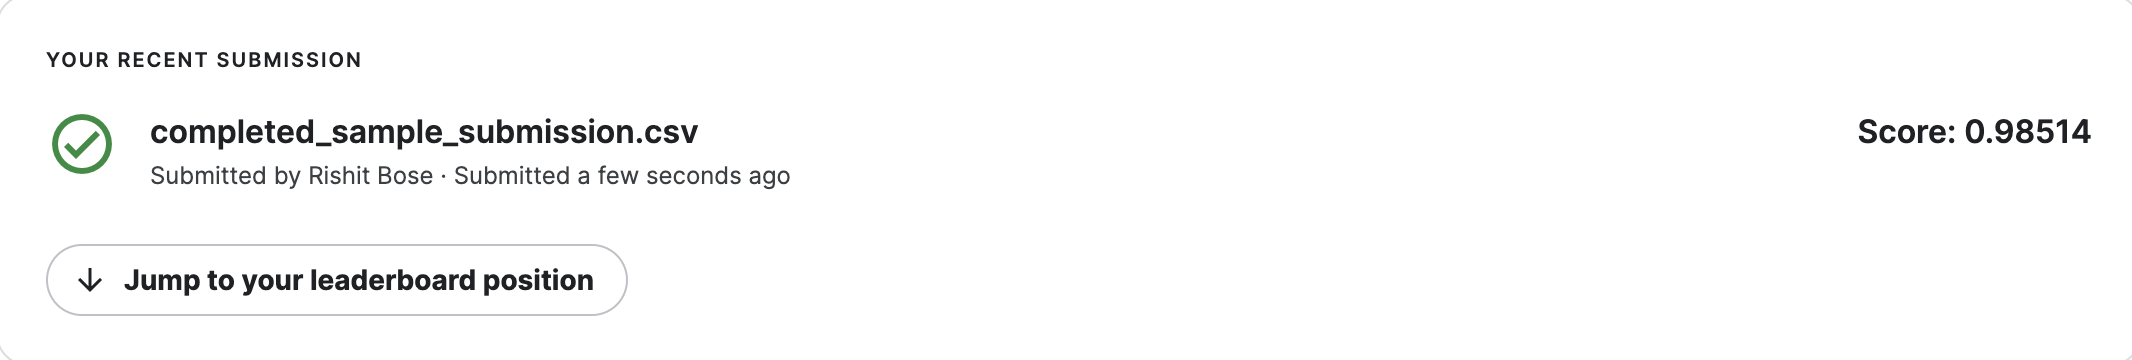

In [120]:
performance = Image.open("/content/Kaggle Digit Recognizer Performance.png")
performance

This model has a 98.514% accuracy